# Tune the algorithms designed for stationary environments

In this notebook I tune the hyper parameters of those algorithms that were designed to work in stationary environments. These include: Epsilon-greedy, UCB1, LinUCB and SimOOS

For this I run them on the tuning set that includes random 2630 points of the dataset without introducing non-stationarity.
In later experiments i will use the tuned parameters for these algorithms.

Here I use data saved in notebook 20.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
from src import evaluation
from src import costs
from plotting.costs import plot_costs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
np.random.seed(42)

## Load data saved in experiment 20

In [6]:
with open('dataset/nursery/nursery_tuning.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

## Algorithm evaluation

In [8]:
BETA = 1

In [9]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [10]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.ones(new_rewards.shape)*np.mean(new_rewards, axis=0)

n_arms = all_rewards.shape[1]



In [11]:
new_contexts.shape, new_rewards.shape

((2630, 5), (2630, 3))

### Stationary costs

In [12]:
cost_change_points = []
interval_count = len(cost_change_points) + 1

In [13]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [14]:
interval_means

[array([0.0174908 , 0.02901429, 0.02463988, 0.02197317, 0.01312037])]

In [15]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [16]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

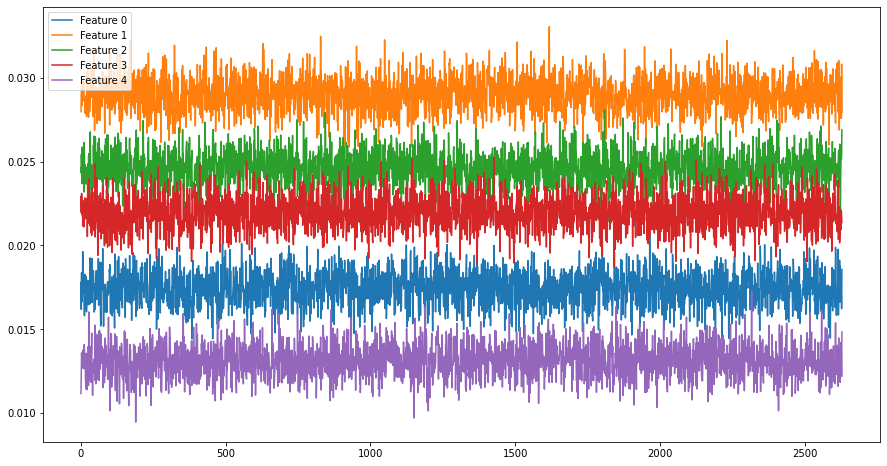

In [17]:
plot_costs(get_costs(), new_contexts.shape[0])

In [18]:
costs_obj = get_costs()

In [19]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [20]:
costs_vector.shape

(2630, 5)

## Plot expected reward

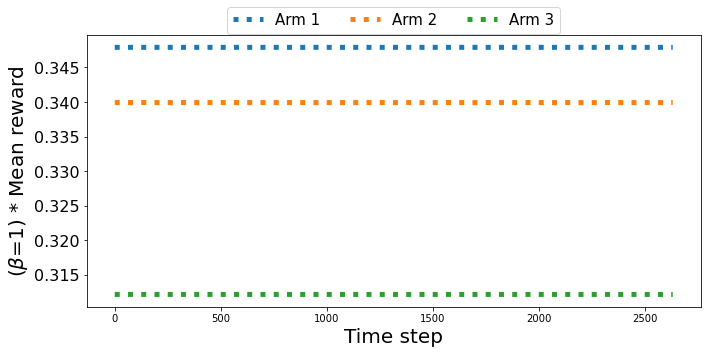

In [29]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)

    
plt.yticks(fontsize=16)
ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


## Plot expected reward minus sum of costs

Min expected gain for arm 1: 0.23405425995074552
Min expected gain for arm 2: 0.22606946907622083
Min expected gain for arm 3: 0.19831281508382542


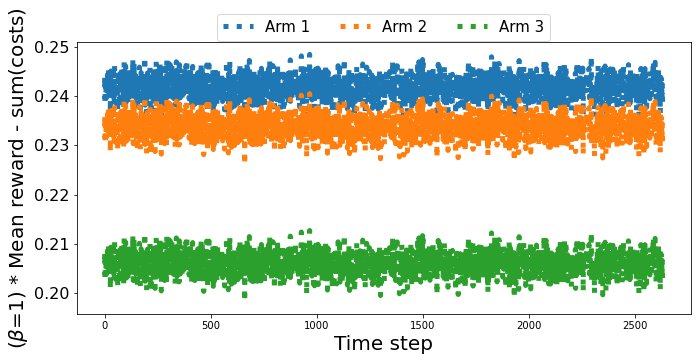

In [30]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")



plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


## Testing on non-stationary data

In [31]:
np.random.seed(42)

In [32]:
TUNING_NUM_OF_TRIALS = all_contexts.shape[0]
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

## Epsilon-greedy

In [33]:
egreedy_gains = {}

for eps in [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):
        egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=new_rewards.shape[1])

        gain_egreedy = evaluation.evaluate_on_synthetic_data(
            egreedy,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_egreedy

    gain_egreedy = np.mean(gains, axis=0)
    egreedy_gains[eps] = gain_egreedy

E-greedy(epsilon=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 914.0
	Total reward: 914.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 913.0
	Total reward: 913.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 913.0
	Total reward: 913.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1109.0
	Total reward: 1109.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 912.0
	Total reward: 912.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 913.0
	Total reward: 913.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Be

In [34]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0];
best_eps

0.03

In [35]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 971.0
	Total reward: 971.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 1089.0
	Total reward: 1089.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 884.0
	Total reward: 884.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 924.0
	Total reward: 924.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 1028.0
	Total reward: 1028.0
	Total cost: 0
Execution time: 0.0s
Average gain: 979.2


## UCB1

In [36]:
ucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        ucb_alg = algorithms.UCB1(
                n_trials=TUNING_NUM_OF_TRIALS,
                n_arms=new_rewards.shape[1],
                alpha=alpha,
            )

        gain_ucb = evaluation.evaluate_on_synthetic_data(
            ucb_alg,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_ucb

    gain_ucb = np.mean(gains, axis=0)
    ucb_gains[alpha] = gain_ucb

UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.001)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.005)
Beta = 1
Total gain: 915.0
	Total reward: 915.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.

In [37]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_ucb

0.6

In [38]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=best_alpha_ucb,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
UCB1 (α=0.6)
Beta = 1
Total gain: 1357.0
	Total reward: 1357.0
	Total cost: 0
Execution time: 0.0s
Average gain: 1357.0


## LinUCB

In [39]:
linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        linucb = algorithms.LinUCB(
            n_trials=TUNING_NUM_OF_TRIALS,
            context_dimension=new_contexts.shape[1],
            n_arms=new_rewards.shape[1],
            alpha=alpha,
        )
        gain_linucb = evaluation.evaluate_on_synthetic_data(
            linucb,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_linucb

    gain_linucb = np.mean(gains, axis=0)
    linucb_gains[alpha] = gain_linucb

LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 1436.7693091283434
	Total reward: 1716.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 1438.7693091283434
	Total reward: 1718.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 1438.7693091283434
	Total reward: 1718.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 1438.7

LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 1689.769309128344
	Total reward: 1969.0
	Total cost: 279.23069087165237
Execution time: 0.1s


In [40]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_linucb

0.5

In [41]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_linucb,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.1s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 1723.7693091283434
	Total reward: 2003.0
	Total cost: 279.23069087165237
Execution time: 0.1s
Average gain: 1723.7693091283431


## SimOOS

In [42]:
simoos_gains = {}


for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.09, 0.1, 0.12, 0.16, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta_SimOOS=BETA,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                new_contexts[:TUNING_NUM_OF_TRIALS],
                new_rewards[:TUNING_NUM_OF_TRIALS],
                costs_vector[:TUNING_NUM_OF_TRIALS],
                beta=BETA,
                stop_after=TUNING_NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_simoos

    gain_simoos = np.mean(gains, axis=0)
    simoos_gains[delta] = gain_simoos

Took 0.0024518966674804688 seconds
Trial 0, time 2022-05-18 11:41:51.308626
Trial 500, time 2022-05-18 11:41:54.071042
Trial 1000, time 2022-05-18 11:41:54.371482
Trial 1500, time 2022-05-18 11:41:55.872349
Trial 2000, time 2022-05-18 11:41:56.022361
Trial 2500, time 2022-05-18 11:41:57.056260
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 1864.1953439365827
	Total reward: 1900.0
	Total cost: 35.8046560634216
Execution time: 5.8s
Took 5.789952754974365 seconds
Took 0.0012030601501464844 seconds
Trial 0, time 2022-05-18 11:41:57.099815
Trial 500, time 2022-05-18 11:42:32.692999
Trial 1000, time 2022-05-18 11:42:35.022494
Trial 1500, time 2022-05-18 11:42:35.618148
Trial 2000, time 2022-05-18 11:42:35.978706
Trial 2500, time 2022-05-18 11:42:36.339882
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 1408.8041909832486
	Total reward: 1641.0
	Total cost: 232.19580901674775
Execution time: 39.3s
Took 39.29766392707825 seconds
Took 0.0011749267578125 seconds
Trial 0, time 2022-05-18 11:4

Trial 2500, time 2022-05-18 12:05:32.254606
SimOOS (beta=1, delta=0.05)
Beta = 1
Total gain: 1254.4834720646274
	Total reward: 1532.0
	Total cost: 277.5165279353701
Execution time: 2.6m
Took 156.68742895126343 seconds
Took 0.001458883285522461 seconds
Trial 0, time 2022-05-18 12:05:33.226486
Trial 500, time 2022-05-18 12:05:46.336829
Trial 1000, time 2022-05-18 12:05:46.973731
Trial 1500, time 2022-05-18 12:05:47.420036
Trial 2000, time 2022-05-18 12:05:47.753689
Trial 2500, time 2022-05-18 12:05:50.282985
SimOOS (beta=1, delta=0.05)
Beta = 1
Total gain: 1790.9955994713118
	Total reward: 1918.0
	Total cost: 127.00440052868912
Execution time: 17.2s
Took 17.248250722885132 seconds
Took 0.0015070438385009766 seconds
Trial 0, time 2022-05-18 12:05:50.476397
Trial 500, time 2022-05-18 12:06:50.594926
Trial 1000, time 2022-05-18 12:07:39.296520
Trial 1500, time 2022-05-18 12:08:07.617291
Trial 2000, time 2022-05-18 12:08:22.108726
Trial 2500, time 2022-05-18 12:08:26.984668
SimOOS (beta=1, d

Trial 500, time 2022-05-18 12:24:30.370255
Trial 1000, time 2022-05-18 12:25:19.757289
Trial 1500, time 2022-05-18 12:25:47.986970
Trial 2000, time 2022-05-18 12:26:02.582837
Trial 2500, time 2022-05-18 12:26:07.521553
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain: 1257.5385294732598
	Total reward: 1535.0
	Total cost: 277.4614705267378
Execution time: 2.6m
Took 157.21072220802307 seconds
Took 0.0013127326965332031 seconds
Trial 0, time 2022-05-18 12:26:08.503676
Trial 500, time 2022-05-18 12:26:28.707389
Trial 1000, time 2022-05-18 12:27:28.280951
Trial 1500, time 2022-05-18 12:28:10.648520
Trial 2000, time 2022-05-18 12:28:32.291432
Trial 2500, time 2022-05-18 12:28:40.696541
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain: 1437.2295209877086
	Total reward: 1684.0
	Total cost: 246.77047901228866
Execution time: 2.6m
Took 153.7502419948578 seconds
Took 0.001190185546875 seconds
Trial 0, time 2022-05-18 12:28:42.255195
Trial 500, time 2022-05-18 12:28:47.800283
Trial 1000, time 2022-0

Trial 500, time 2022-05-18 12:42:46.723522
Trial 1000, time 2022-05-18 12:42:47.009261
Trial 1500, time 2022-05-18 12:42:48.537782
Trial 2000, time 2022-05-18 12:42:48.699357
Trial 2500, time 2022-05-18 12:42:49.729335
SimOOS (beta=1, delta=0.3)
Beta = 1
Total gain: 1863.195343936583
	Total reward: 1899.0
	Total cost: 35.8046560634216
Execution time: 5.7s
Took 5.662585973739624 seconds
Took 0.00589299201965332 seconds
Trial 0, time 2022-05-18 12:42:49.778104
Trial 500, time 2022-05-18 12:42:54.765819
Trial 1000, time 2022-05-18 12:42:55.825824
Trial 1500, time 2022-05-18 12:42:56.981930
Trial 2000, time 2022-05-18 12:42:57.791109
Trial 2500, time 2022-05-18 12:42:58.946583
SimOOS (beta=1, delta=0.3)
Beta = 1
Total gain: 1591.766867226238
	Total reward: 1623.0
	Total cost: 31.23313277376795
Execution time: 9.2s
Took 9.218798875808716 seconds
Took 0.0012309551239013672 seconds
Trial 0, time 2022-05-18 12:42:58.998385
Trial 500, time 2022-05-18 12:43:34.274497
Trial 1000, time 2022-05-18 

Trial 500, time 2022-05-18 13:02:30.698741
Trial 1000, time 2022-05-18 13:02:33.438091
Trial 1500, time 2022-05-18 13:02:34.045564
Trial 2000, time 2022-05-18 13:02:34.382989
Trial 2500, time 2022-05-18 13:02:34.751039
SimOOS (beta=1, delta=0.7)
Beta = 1
Total gain: 1407.397924931248
	Total reward: 1638.0
	Total cost: 230.60207506874826
Execution time: 40.4s
Took 40.360759973526 seconds
Took 0.0012810230255126953 seconds
Trial 0, time 2022-05-18 13:02:34.811797
Trial 500, time 2022-05-18 13:03:10.888496
Trial 1000, time 2022-05-18 13:03:13.636483
Trial 1500, time 2022-05-18 13:03:14.240344
Trial 2000, time 2022-05-18 13:03:14.576420
Trial 2500, time 2022-05-18 13:03:14.929966
SimOOS (beta=1, delta=0.7)
Beta = 1
Total gain: 1402.3979249312483
	Total reward: 1633.0
	Total cost: 230.60207506874826
Execution time: 40.2s
Took 40.18428182601929 seconds
Took 0.0013051033020019531 seconds
Trial 0, time 2022-05-18 13:03:14.997455
Trial 500, time 2022-05-18 13:04:12.534406
Trial 1000, time 2022-

Trial 500, time 2022-05-18 13:25:07.427969
Trial 1000, time 2022-05-18 13:25:09.785153
Trial 1500, time 2022-05-18 13:25:10.401348
Trial 2000, time 2022-05-18 13:25:10.757887
Trial 2500, time 2022-05-18 13:25:11.108060
SimOOS (beta=1, delta=0.99)
Beta = 1
Total gain: 1409.8324800433124
	Total reward: 1642.0
	Total cost: 232.1675199566841
Execution time: 39.3s
Took 39.33080077171326 seconds


In [43]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_delta_simoos

0.005

In [44]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=best_delta_simoos,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0031490325927734375 seconds
Trial 0, time 2022-05-18 13:25:11.358393
Trial 500, time 2022-05-18 13:25:16.018426
Trial 1000, time 2022-05-18 13:25:49.823876
Trial 1500, time 2022-05-18 13:26:45.894661
Trial 2000, time 2022-05-18 13:27:24.481630
Trial 2500, time 2022-05-18 13:27:41.091986
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 1469.0109108910506
	Total reward: 1682.0
	Total cost: 212.9890891089465
Execution time: 2.5m
Took 151.54310703277588 seconds
Took 0.0014338493347167969 seconds
Trial 0, time 2022-05-18 13:27:42.902921
Trial 500, time 2022-05-18 13:27:47.858072
Trial 1000, time 2022-05-18 13:27:48.903155
Trial 1500, time 2022-05-18 13:27:50.061859
Trial 2000, time 2022-05-18 13:27:50.840787
Trial 2500, time 2022-05-18 13:27:52.001731
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 1590.766867226238
	Total reward: 1622.0
	Total cost: 31.23313277376795
Execution time: 9.1s
Took 9.144093036651611 seconds
Took 0.0011219978332519531 seconds
Trial 0, time 2022-05-18 13

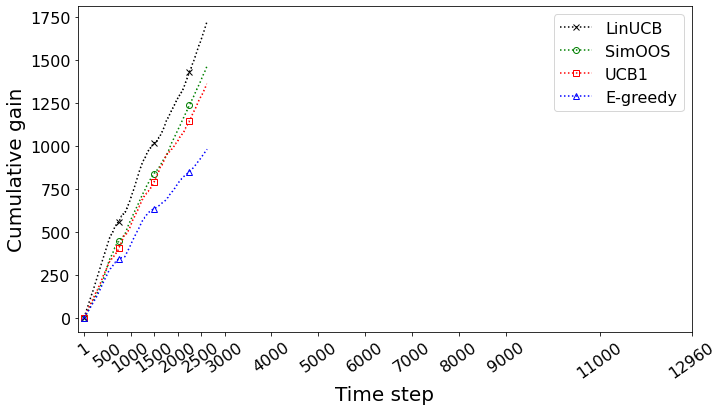

In [45]:
plot_gains({
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'SimOOS': gain_simoos,
},
)


In [46]:
best_eps # Epsilon-greedy

0.03

In [47]:
best_alpha_ucb # UCB1

0.6

In [48]:
best_alpha_linucb # LinUCB

0.5

In [49]:
best_delta_simoos # SimOOS

0.005